# Network Analysis of the Primary Healthcare Facility Referral System in the Philippines
##### By: Elijah Justin Medina and Jomilynn Rebanal

This project aims to analyze to referral system among health units in the Philippines in order to identify the characteristics and consequently, the robustness of this system. The main data used in this analysis are geospatial coordinates of different health units in the network &mdash; barangay health stations (BHS), rural health units (RHU), and hospitals. The network is supplemented with bed capacity information of the different health units. The aforementioned data was obtained from the DOH Data Collect app v2.1 and the National Health Facility Registry.

##### Preliminaries

In [4]:
import pandas as pd 
import numpy as np 
from glob import glob 
import sys
import locale
from geopy.distance import vincenty
import warnings

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize, precision=2) 
pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 1000)

## Data Processing and Exploratory Data Analysis
Before performing the analysis, the data must be cleaned to standardize text and minimize effect of errors (e.g. typographical, encoding, outliers). The goal of this processing is to prepare the data for network analysis.

### Merging of multiple, separated files

##### Geographic Coordinates (Health Facility names and coordinates)

In [122]:
files = glob('Geographic Coordinates/*.xlsx')
cols = ['Health Facility Code Short', 'Facility Name', 'Health Facility Type',
        'Region Name                                             ', 
        'Province Name ', 'City/Municipality Name', 'Barangay Name', 
        'Latitude', 'Longitude', 'Service Capability', 'Licensing Status', 
        'Bed Capacity']

HF_list = pd.DataFrame()
        
for f in files:
    data = pd.read_excel(f, usecols=cols)
    HF_list = HF_list.append(data)

In [123]:
HF_list.isnull().sum() # Verify mismatched fields across different excel files

In [124]:
HF_list.columns = ['SHORT_HFCODE', 'HF_NAME', 'HF_TYPE', 'REGION', 'PROVINCE', 
                  'MUNI_CITY', 'BRGY', 'LAT', 'LONG', 'SERVICE_CAP', 
                  'LICENSING', 'BED_CAP']

str_cols = ['HF_NAME', 'HF_TYPE', 'REGION', 'PROVINCE', 'MUNI_CITY', 'BRGY', 
            'SERVICE_CAP', 'LICENSING', 'BED_CAP']

HF_list[str_cols] = HF_list[str_cols].fillna('UNKNOWN').apply(lambda x: x.str.upper().str.strip())
HF_list['SHORT_HFCODE'] = HF_list['SHORT_HFCODE'].astype(int)

HF_list.to_excel('cleaned/HFList_cleaned.xlsx') #Store the combined dataframe

##### Rural Health Unit

In [127]:
rhu = pd.read_excel('rhu2018.xlsx', sheet_name='MAIN', na_values='None')

In [128]:
str_cols = ['HF_NAME', 'REGION', 'PROVINCE', 'MUNI_CITY', 'BRGY',
            'STREET_NAME', 'BUILDING', 'FACILITY_HEAD', 'DETACHED', 'BRGYS', 
            'SDN', 'SDN_NAME', 'REF1_NAME', 'REF1_SAMEPROV', 
            'REF1_REF1A', 'REF1A_SAMEPROV', 'REF2_NAME', 'REF3_NAME',  
            'AMB_ACCESS', 'AMB_OWN', 'PHIC_ACC', 'PHIC_PACKAGES', 'PHIC_MCP', 
            'PHIC_PCB1', 'PHIC_MALARIA', 'PHIC_TBDOTS', 'PHIC_ABTC', 
            'PHIC_NCP', 'PHIC_OTH']
code_cols = ['id', 'REF1_CODE', 'REF2_CODE', 'REF3_CODE']
float_cols = ['REF1_DIST', 'REF1_TRAVEL', 'REF2_DIST', 'REF2_TRAVEL',
             'REF3_DIST', 'REF3_TRAVEL']
# int_cols = ['id', 'BHS_COUNT','CATCHMENT', 'REF1_CODE', 'REF2_CODE', 
#             'REF3_CODE',  'MD_NO', 'MD_AUG', 'MD_TOTAL','MD_FT', 'MD_PT', 
#             'MD_VISIT', 'RN_NO', 'RN_AUG', 'RN_TOTAL', 'RN_FT', 'RN_PT', 
#             'RN_VISIT', 'MW_NO', 'MW_AUG', 'MW_TOTAL', 'MW_FT', 'MW_PT', 
#             'MW_VISIT']

rhu[str_cols] = rhu[str_cols].apply(lambda x: x.str.upper().str.strip())
rhu[code_cols] = rhu[code_cols].fillna(0).astype(int)
rhu[float_cols] = rhu[float_cols].astype(float)

rhu[str_cols] = rhu[str_cols].fillna('UNKNOWN')

# Extract short code for merging with the Geographic Coordinates files
rhu['SHORT_HFCODE'] = rhu['HF_CODE'].apply(lambda x: int(x[-6:]))

rhu.to_excel('cleaned/rhu_cleaned.xlsx')

### Impute missing information from other tables
As the data is being processed from different tables, the other tables can be used to fill some missing information. Aside from imputing missing information, coordinates outside the Philippines are identified.

In [7]:
# Bounding box for the Philippines (manually extracted from Google).
long_min, lat_min, long_max, lat_max = (117.17427453, 5.58100332277, 126.537423944, 18.5052273625)

In [8]:
HF_list = pd.read_excel('cleaned/HFList_cleaned.xlsx')

# Groupby the data to account for duplicate names for different codes
HF_dict = HF_list[['HF_NAME', 'SHORT_HFCODE']].groupby('HF_NAME')['SHORT_HFCODE'].apply(set).to_dict()
latlong_dict = HF_list[['SHORT_HFCODE', 'LAT', 'LONG']].set_index('SHORT_HFCODE').to_dict()


#### RHU

In [9]:
rhu = pd.read_excel('cleaned/rhu_cleaned.xlsx')

# Create copies of the dataframe for later use
rhu2 = rhu.copy()
rhu3 = rhu.copy()

##### Fill missing REF1 Codes

In [10]:
cols = ['id', 'HF_CODE', 'SHORT_HFCODE', 'HF_NAME', 'REGION', 'PROVINCE', 'MUNI_CITY', 'BRGY',
            'STREET_NAME', 'BUILDING', 'FACILITY_HEAD', 'DETACHED', 'BRGYS', 
            'SDN', 'SDN_NAME', 'REF1_NAME', 'REF1_SAMEPROV', 
            'REF1_REF1A', 'REF1A_SAMEPROV', 'REF2_NAME', 'REF3_NAME',  
            'AMB_ACCESS', 'AMB_OWN', 'PHIC_ACC', 'PHIC_PACKAGES', 'PHIC_MCP', 
            'PHIC_PCB1', 'PHIC_MALARIA', 'PHIC_TBDOTS', 'PHIC_ABTC', 
            'PHIC_NCP', 'PHIC_OTH', 'REF1_CODE', 'REF1_DIST', 'REF1_TRAVEL',
            'REF2_CODE', 'REF2_DIST', 'REF2_TRAVEL',
            'REF3_CODE', 'REF3_DIST', 'REF3_TRAVEL']

rhu = rhu[cols]

# Using the health facility list, complete the RHU data
rhu.loc[rhu['REF1_CODE']==0, 'REF_CODE'] = rhu[rhu['REF1_CODE']==0]['REF1_NAME'].map(HF_dict)

In [11]:
temp = rhu[['SHORT_HFCODE', 'REF_CODE']].dropna().copy()

# This dataframe contains the HF codes of one health facility to other facilities.
temp.head()

,SHORT_HFCODE,REF_CODE
8,2228,{3313}
20,6698,{3313}
29,147,{2703}
36,2033,{3667}
37,2184,{2703}


In [12]:
# Out of all the mapped referred facilities, the closest facility is used as the actual referred facility
# Slight pre-processing: "place" the health facilities without coordinates to southwest of southwest Philippine boundary (lat_min - 10, long_min - 20) or northeast of northeast Philippine boundary
temp_dict = pd.DataFrame(temp.apply(lambda x: min([(vincenty((latlong_dict['LAT'][x['SHORT_HFCODE']] if latlong_dict['LAT'][x['SHORT_HFCODE']]==latlong_dict['LAT'][x['SHORT_HFCODE']] else lat_min-10,
                                                  latlong_dict['LONG'][x['SHORT_HFCODE']] if latlong_dict['LONG'][x['SHORT_HFCODE']]==latlong_dict['LONG'][x['SHORT_HFCODE']] else long_min-20), 
                                                 (latlong_dict['LAT'][i] if latlong_dict['LAT'][i]==latlong_dict['LAT'][i] else lat_max+10,
                                                  latlong_dict['LONG'][i] if latlong_dict['LONG'][i]==latlong_dict['LONG'][i] else long_max+20)).km, i, x['SHORT_HFCODE']) for i in x['REF_CODE']], key=lambda x: x[0]), axis=1).tolist()).set_index(2).to_dict()

rhu['REF_CODE'] = rhu['SHORT_HFCODE'].map(temp_dict[1])
rhu.loc[rhu['REF1_CODE']!=0, 'REF_CODE'] = rhu.loc[rhu['REF1_CODE']!=0, 'REF1_CODE']

##### Fill missing REF2 Codes

The data contains up to three referred facilities so the same processing is performed for the second and third HF code.

In [13]:
rhu2.loc[rhu2['REF2_CODE']==0, 'REF_CODE'] = rhu2[rhu2['REF2_CODE']==0]['REF2_NAME'].map(HF_dict)

temp = rhu2[['SHORT_HFCODE', 'REF_CODE']].dropna().copy()
temp_dict = pd.DataFrame(temp.apply(lambda x: min([(vincenty((latlong_dict['LAT'][x['SHORT_HFCODE']] if latlong_dict['LAT'][x['SHORT_HFCODE']]==latlong_dict['LAT'][x['SHORT_HFCODE']] else lat_min-10,
                                                  latlong_dict['LONG'][x['SHORT_HFCODE']] if latlong_dict['LONG'][x['SHORT_HFCODE']]==latlong_dict['LONG'][x['SHORT_HFCODE']] else long_min-20), 
                                                 (latlong_dict['LAT'][i] if latlong_dict['LAT'][i]==latlong_dict['LAT'][i] else lat_max+10,
                                                  latlong_dict['LONG'][i] if latlong_dict['LONG'][i]==latlong_dict['LONG'][i] else long_max+20)).km, i, x['SHORT_HFCODE']) for i in x['REF_CODE']], key=lambda x: x[0]), axis=1).tolist()).set_index(2).to_dict()

rhu2['REF_CODE'] = rhu2['SHORT_HFCODE'].map(temp_dict[1])
rhu2.loc[rhu2['REF2_CODE']!=0, 'REF_CODE'] = rhu2.loc[rhu2['REF2_CODE']!=0, 'REF2_CODE']

##### Fill missing REF3 Codes

In [14]:
rhu3.loc[rhu3['REF3_CODE']==0, 'REF_CODE'] = rhu3[rhu3['REF3_CODE']==0]['REF3_NAME'].map(HF_dict)

temp = rhu3[['SHORT_HFCODE', 'REF_CODE']].dropna().copy()
temp_dict = pd.DataFrame(temp.apply(lambda x: min([(vincenty((latlong_dict['LAT'][x['SHORT_HFCODE']] if latlong_dict['LAT'][x['SHORT_HFCODE']]==latlong_dict['LAT'][x['SHORT_HFCODE']] else lat_min-10,
                                                  latlong_dict['LONG'][x['SHORT_HFCODE']] if latlong_dict['LONG'][x['SHORT_HFCODE']]==latlong_dict['LONG'][x['SHORT_HFCODE']] else long_min-20), 
                                                 (latlong_dict['LAT'][i] if latlong_dict['LAT'][i]==latlong_dict['LAT'][i] else lat_max+10,
                                                  latlong_dict['LONG'][i] if latlong_dict['LONG'][i]==latlong_dict['LONG'][i] else long_max+20)).km, i, x['SHORT_HFCODE']) for i in x['REF_CODE']], key=lambda x: x[0]), axis=1).tolist()).set_index(2).to_dict()

rhu3['REF_CODE'] = rhu3['SHORT_HFCODE'].map(temp_dict[1])
rhu3.loc[rhu3['REF3_CODE']!=0, 'REF_CODE'] = rhu3.loc[rhu3['REF3_CODE']!=0, 'REF3_CODE']

In [15]:
rhu.dropna(subset=['REF_CODE'], inplace=True)
rhu2.dropna(subset=['REF_CODE'], inplace=True)
rhu3.dropna(subset=['REF_CODE'], inplace=True)

##### Combine the processed dataframes

In [16]:
rhu.rename({'REF1_DIST':'REF_DIST', 'REF1_TRAVEL':'REF_TRAVEL', 'REF1_NAME':'REF_NAME'}, axis=1, inplace=True)
rhu2.rename({'REF2_DIST':'REF_DIST', 'REF2_TRAVEL':'REF_TRAVEL', 'REF1_NAME':'REF_NAME'}, axis=1, inplace=True)
rhu3.rename({'REF3_DIST':'REF_DIST', 'REF3_TRAVEL':'REF_TRAVEL', 'REF1_NAME':'REF_NAME'}, axis=1, inplace=True)

In [17]:
cols2 = ['SHORT_HFCODE', 'REF_CODE']
rhu_edges = rhu[cols2].append(rhu2[cols2]).append(rhu3[cols2])

In [18]:
# Add a column identifying the type of facility for the later network analysis

rhu_edges['HF_TYPE'] = 'RHU'

In [19]:
HF_list[['SHORT_HFCODE', 'LAT', 'LONG']].describe()

,SHORT_HFCODE,LAT,LONG
count,"29,424.00","25,752.00","25,752.00"
mean,"19,505.19",12.27,122.49
std,"11,203.47",7.11,4.42
min,1.00,0.00,0.00
25%,"9,724.75",9.52,121.02
50%,"19,799.50",12.73,122.38
75%,"29,542.25",14.81,124.16
max,"38,002.00","1,000.00",126.58


##### Map lat-long to the HF codes

In [25]:
rhu_edges['source_lat'] = rhu_edges['SHORT_HFCODE'].map(latlong_dict['LAT'])
rhu_edges['source_long'] = rhu_edges['SHORT_HFCODE'].map(latlong_dict['LONG'])
rhu_edges['target_lat'] = rhu_edges['REF_CODE'].map(latlong_dict['LAT'])
rhu_edges['target_long'] = rhu_edges['REF_CODE'].map(latlong_dict['LONG'])

##### Set lat-long outside PH to NaN

In [26]:
rhu_edges.loc[~((rhu_edges['source_lat'].between(lat_min, lat_max)) & (rhu_edges['source_long'].between(
    long_min, long_max))), ['source_lat', 'source_long']] = np.nan
rhu_edges.loc[~((rhu_edges['target_lat'].between(lat_min, lat_max)) & (rhu_edges['target_long'].between(
    long_min, long_max))), ['target_lat', 'target_long']] = np.nan

##### Measure distance using lat-long for non-NaN HF pairs

In [27]:
missing_latlong = ~rhu_edges[['source_lat', 'source_long', 'target_lat', 'target_long']].isnull().sum(axis=1).astype(bool)
rhu_edges.loc[missing_latlong, 'DIST'] = rhu_edges.loc[missing_latlong, ['source_lat', 'source_long', 'target_lat', 'target_long']].apply(lambda x: vincenty((x['source_lat'], x['source_long']), (x['target_lat'], x['target_long'])).km, axis=1)

rhu_edges.loc[rhu_edges['DIST']==0, 'DIST'] = 1

##### Check for outliers
In this case, referral between facilities that are too high are classified as outliers. The threshold to be used for filtering out these outliers is subject to the researcher's choice. The unit of distance is in kilometers. Note that since the distance is extracted from coordinates, errors in encoding will change the actual coordinates of the facilities, therefore making changes to the distance (e.g. dividing by a constant factor) cannot be done. Instead, other imputing techinques are used to fill for missing distance data.

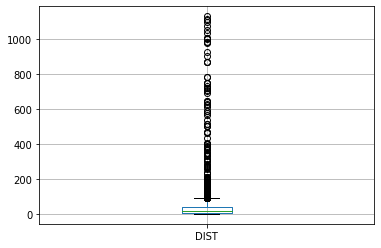

In [29]:
B = rhu_edges.boxplot('DIST', return_type='both')

In [30]:
outliers = [i.get_ydata()[1] for i in B.lines['whiskers']]
rhu_edges.loc[rhu_edges['DIST'] > outliers[1], 'DIST'] = np.nan

In [31]:
outliers

[0.0006040641840882818, 88.56724901828711]

In [32]:
muni_dict = HF_list[['SHORT_HFCODE', 'MUNI_CITY', 'PROVINCE']].set_index('SHORT_HFCODE').to_dict()

##### Impute distance from municipality
With the municipality information of the facilities, the distance of different health units are imputed using the median. The assumption is that within the same municipality, the distance of referring facilities are more or less similar. For tracking, the source of the distance information is stored.

In [33]:
rhu_edges['muni_city'] = rhu_edges['SHORT_HFCODE'].map(muni_dict['MUNI_CITY'])
mean_dist_city = rhu_edges.groupby('muni_city')['DIST'].median().to_dict()

imputed_muni = ~(rhu_edges.loc[rhu_edges['DIST'].isnull(), 'muni_city'].map(mean_dist_city).isnull())
imputed_muni = imputed_muni[imputed_muni].index
rhu_edges.loc[imputed_muni, "IMPUTED"] = "MUNI" 
rhu_edges.loc[rhu_edges['DIST'].isnull(), 'DIST'] = rhu_edges.loc[rhu_edges['DIST'].isnull(), 'muni_city'].map(mean_dist_city)

##### Impute distance from province
For those facilities without municipality information, the province is used.

In [34]:
rhu_edges['province'] = rhu_edges['SHORT_HFCODE'].map(muni_dict['PROVINCE'])
mean_dist_prov = rhu_edges.groupby('province')['DIST'].median().to_dict()

imputed_prov = ~(rhu_edges.loc[rhu_edges['DIST'].isnull(), 'province'].map(mean_dist_prov).isnull())
imputed_prov = imputed_prov[imputed_prov].index

rhu_edges.loc[imputed_prov, "IMPUTED"] = "PROV"
rhu_edges.loc[rhu_edges['DIST'].isnull(), 'DIST'] = rhu_edges.loc[rhu_edges['DIST'].isnull(), 'province'].map(mean_dist_prov)

In [35]:
rhu_edges['DIST'].isnull().sum()

17

If after all these, the referring facilities still do not have distance information, the connection between the facilities is dropped. 

In [36]:
rhu_edges.dropna(subset=['DIST'], inplace=True)

In [37]:
prov_HF_dict = rhu_edges.groupby('province')[['SHORT_HFCODE', 'REF_CODE']].agg(set).rename({'SHORT_HFCODE':'RHU', 'REF_CODE':'HOSP'}, axis=1).to_dict()

In [38]:
rhu_edges['REF_CODES'] = [set(rhu_edges[~rhu_edges[['target_lat', 'target_long']].isnull().sum(axis=1).astype(bool)]['REF_CODE'])] * len(rhu_edges)

In [39]:
rhu_edges = rhu_edges[rhu_edges['REF_CODE']!=rhu_edges['SHORT_HFCODE']]

##### Connect nearest neighbors
The referrals above are based on actual data, i.e. actual referrals from facility to facility. This list is supplemented with the three nearest facilities, regardless of being the same facilities as the actual data.

In [40]:
n = 3 #num of nearest neighbors to connect
temp = rhu_edges[['SHORT_HFCODE', 'REF_CODES']].dropna().drop_duplicates(subset='SHORT_HFCODE').copy()
df_neighbors = pd.DataFrame(temp.apply(lambda x: sorted([(vincenty((latlong_dict['LAT'][x['SHORT_HFCODE']] if latlong_dict['LAT'][x['SHORT_HFCODE']]==latlong_dict['LAT'][x['SHORT_HFCODE']] else lat_min-10,
                                                  latlong_dict['LONG'][x['SHORT_HFCODE']] if latlong_dict['LONG'][x['SHORT_HFCODE']]==latlong_dict['LONG'][x['SHORT_HFCODE']] else long_min-20), 
                                                 (latlong_dict['LAT'][i] if latlong_dict['LAT'][i]==latlong_dict['LAT'][i] else lat_max+10,
                                                  latlong_dict['LONG'][i] if latlong_dict['LONG'][i]==latlong_dict['LONG'][i] else long_max+20)).km, i, x['SHORT_HFCODE']) for i in x['REF_CODES'] if i!=x['SHORT_HFCODE']], key=lambda x: x[0])[:n], axis=1).tolist())#.set_index(2).to_dict()

In [41]:
df_neighbors_edges = pd.DataFrame(df_neighbors[0].append(df_neighbors[1]).append(df_neighbors[2]).tolist(), columns=['DIST', 'REF_CODE', 'SHORT_HFCODE'])

In [42]:
df_neighbors_edges['IMPUTED'] = 'NEAREST_NEIGHBOR'

In [43]:
rhu_edges[['SHORT_HFCODE', 'REF_CODE', 'DIST', 'IMPUTED']]

,SHORT_HFCODE,REF_CODE,DIST,IMPUTED
0,25,"32,170.00",0.00,NaN
1,105,"5,940.00",0.41,NaN
2,106,"3,313.00",11.13,NaN
4,137,"3,313.00",11.29,NaN
5,1760,"6,513.00",5.98,NaN
...,...,...,...,...
2296,6814,273.00,51.12,NaN
2297,7045,273.00,15.07,NaN
2298,7696,273.00,29.09,NaN
2299,8861,273.00,16.35,NaN


In [44]:
rhu_edges = rhu_edges[['SHORT_HFCODE', 'REF_CODE', 'DIST', 'IMPUTED']].append(df_neighbors_edges)

In [45]:
rhu_edges.loc[rhu_edges['DIST'] > outliers[1], 'DIST'] = np.nan
rhu_edges.loc[rhu_edges['DIST']==0, 'DIST'] = 1

In [46]:
rhu_edges.describe()

,DIST,REF_CODE,SHORT_HFCODE
count,"12,157.00","12,330.00","12,330.00"
mean,16.11,"4,600.62","5,816.23"
std,16.55,"7,159.54","6,469.21"
min,0.00,1.00,10.00
25%,3.39,622.00,"2,307.00"
50%,11.07,"2,850.00","4,234.00"
75%,22.87,"5,139.00","7,062.00"
max,88.57,"261,101.00","36,628.00"


#### BHS
The same processing done for the rural health units is performed for the barangay health stations.

In [47]:
bhs = pd.read_excel('bhs2018.xlsx', sheet_name='MAIN', na_values='None')

In [48]:
str_cols = ['HF_NAME', 'REGION', 'PROVINCE', 'MUNI_CITY', 'BRGY',
            'STREET_NAME', 'BUILDING', 'FACILITY_HEAD', 'DETACHED', 
            'BRGYS', 'RHU_NAME', 'RHU_SAME_CTY', 'RHU_NOTSAME_CTY',
            'AMB_ACCESS']
code_cols = ['id', 'RHU_CODE']
float_cols = ['RHU_DIST', 'RHU_TRAVEL']
# int_cols = ['CATCHMENT', 'MD_NO', 'MD_AUG', 'MD_TOTAL',
#        'MD_FT', 'MD_PT', 'MD_VISIT', 'RN_NO', 'RN_AUG', 'RN_TOTAL', 'RN_FT',
#        'RN_PT', 'RN_VISIT', 'MW_NO', 'MW_AUG', 'MW_TOTAL', 'MW_FT', 'MW_PT',
#        'MW_VISIT', 'BHW_NO']

bhs[str_cols] = bhs[str_cols].apply(lambda x: x.str.upper().str.strip())
bhs[code_cols] = bhs[code_cols].fillna(0).astype(int)
bhs[float_cols] = bhs[float_cols].astype(float)

bhs[str_col] = bhs[str_col].fillna('UNKNOWN')
bhs['SHORT_HFCODE'] = bhs['HF_CODE'].apply(lambda x: int(x[-6:]))
bhs.to_excel('cleaned/bhs_cleaned.xlsx')

##### Fill missing RHU Codes

In [49]:
bhs = pd.read_excel('cleaned/bhs_cleaned.xlsx')

In [50]:
bhs.loc[bhs['RHU_CODE']==0, 'REF_CODE'] = bhs[bhs['RHU_CODE']==0]['RHU_NAME'].map(HF_dict)

In [51]:
temp = bhs[['SHORT_HFCODE', 'REF_CODE']].dropna().copy()
temp_dict = pd.DataFrame(temp.apply(lambda x: min([(vincenty((latlong_dict['LAT'][x['SHORT_HFCODE']] if latlong_dict['LAT'][x['SHORT_HFCODE']]==latlong_dict['LAT'][x['SHORT_HFCODE']] else lat_min-10,
                                                  latlong_dict['LONG'][x['SHORT_HFCODE']] if latlong_dict['LONG'][x['SHORT_HFCODE']]==latlong_dict['LONG'][x['SHORT_HFCODE']] else long_min-20), 
                                                 (latlong_dict['LAT'][i] if latlong_dict['LAT'][i]==latlong_dict['LAT'][i] else lat_max+10,
                                                  latlong_dict['LONG'][i] if latlong_dict['LONG'][i]==latlong_dict['LONG'][i] else long_max+20)).km, i, x['SHORT_HFCODE']) for i in x['REF_CODE']], key=lambda x: x[0]), axis=1).tolist()).set_index(2).to_dict()

In [35]:
bhs['DIST'].isnull().sum()

17

In [53]:
bhs.dropna(subset=['REF_CODE'], inplace=True)

In [54]:
cols = ['SHORT_HFCODE', 'REF_CODE']

In [55]:
bhs = bhs[cols]
bhs['HF_TYPE'] = 'BHS'

In [56]:
bhs['source_lat'] = bhs['SHORT_HFCODE'].map(latlong_dict['LAT'])
bhs['source_long'] = bhs['SHORT_HFCODE'].map(latlong_dict['LONG'])
bhs['target_lat'] = bhs['REF_CODE'].map(latlong_dict['LAT'])
bhs['target_long'] = bhs['REF_CODE'].map(latlong_dict['LONG'])

In [57]:
bhs.loc[~((bhs['source_lat'].between(lat_min, lat_max)) & (bhs['source_long'].between(
    long_min, long_max))), ['source_lat', 'source_long']] = np.nan
bhs.loc[~((bhs['target_lat'].between(lat_min, lat_max)) & (bhs['target_long'].between(
    long_min, long_max))), ['target_lat', 'target_long']] = np.nan

In [58]:
missing_latlong = ~bhs[['source_lat', 'source_long', 'target_lat', 'target_long']].isnull().sum(axis=1).astype(bool)
bhs.loc[missing_latlong, 'DIST'] = bhs.loc[missing_latlong, ['source_lat', 'source_long', 'target_lat', 'target_long']].apply(lambda x: vincenty((x['source_lat'], x['source_long']), (x['target_lat'], x['target_long'])).km, axis=1)

In [59]:
bhs.loc[bhs['DIST']==0, 'DIST'] = 1

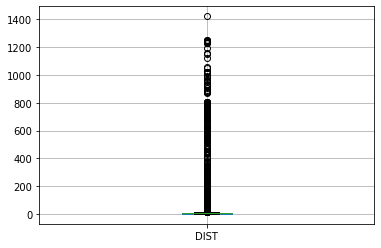

In [60]:
B = bhs.boxplot('DIST', return_type='both')

In [61]:
outliers = [i.get_ydata()[1] for i in B.lines['whiskers']]

In [62]:
outliers

[0.00011063857573315692, 15.946669430143814]

In [63]:
outliers = [i.get_ydata()[1] for i in B.lines['whiskers']]
bhs.loc[bhs['DIST'] > outliers[1], 'DIST'] = np.nan

In [64]:
muni_dict = HF_list[['SHORT_HFCODE', 'MUNI_CITY', 'PROVINCE']].set_index('SHORT_HFCODE').to_dict()

In [65]:
bhs['muni_city'] = bhs['SHORT_HFCODE'].map(muni_dict['MUNI_CITY'])
mean_dist_city = bhs.groupby('muni_city')['DIST'].mean().to_dict()

imputed_muni = ~(bhs.loc[bhs['DIST'].isnull(), 'muni_city'].map(mean_dist_city).isnull())
imputed_muni = imputed_muni[imputed_muni].index
bhs.loc[imputed_muni, "IMPUTED"] = "MUNI" 
bhs.loc[bhs['DIST'].isnull(), 'DIST'] = bhs.loc[bhs['DIST'].isnull(), 'muni_city'].map(mean_dist_city)

In [66]:
bhs['province'] = bhs['SHORT_HFCODE'].map(muni_dict['PROVINCE'])
mean_dist_prov = bhs.groupby('province')['DIST'].mean().to_dict()

imputed_prov = ~(bhs.loc[bhs['DIST'].isnull(), 'province'].map(mean_dist_prov).isnull())
imputed_prov = imputed_prov[imputed_prov].index

bhs.loc[imputed_prov, "IMPUTED"] = "PROV"
bhs.loc[bhs['DIST'].isnull(), 'DIST'] = bhs.loc[bhs['DIST'].isnull(), 'province'].map(mean_dist_prov)

In [67]:
bhs['DIST'].isnull().sum()

55

In [68]:
bhs.dropna(subset=['DIST'], inplace=True)

In [69]:
bhs = bhs[['SHORT_HFCODE', 'REF_CODE', 'DIST', 'IMPUTED']]

In [70]:
bhs = bhs[bhs['REF_CODE'] != bhs['SHORT_HFCODE']]

In [71]:
edge_list = rhu_edges.append(bhs)
edge_list

,DIST,IMPUTED,REF_CODE,SHORT_HFCODE
0,0.00,NaN,"32,170.00",25
1,0.41,NaN,"5,940.00",105
2,11.13,NaN,"3,313.00",106
4,11.29,NaN,"3,313.00",137
5,5.98,NaN,"6,513.00",1760
...,...,...,...,...
19775,3.89,PROV,"5,828.00",36080
19776,3.89,PROV,"3,257.00",31557
19780,3.89,PROV,261.00,31561
19781,3.89,PROV,"2,610.00",36436


In [72]:
edge_list = edge_list.groupby(['REF_CODE', 'SHORT_HFCODE'])[['IMPUTED', 'DIST']].agg({'DIST':'mean', 'IMPUTED':'first'}).reset_index()

In [73]:
edge_list.to_excel('edge_list.xlsx', index=False)

## Network Analysis

Using the facilities as nodes and the referral as edges, a tripartite network of BHS, RHU, and hospitals is created. The characteristics of the healthcare provider network for different regions are characterized and explored in this section. The main metric used in the analysis is degree and path length. 

In [54]:
import pandas as pd
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

In [3]:
nodes = pd.read_excel("nodeslist.xlsx")
edges = pd.read_excel("edge_list.xlsx")

For the succeeding analysis, the imputed distances using the nearest neighbors are not included.

In [5]:
edges = edges[(edges['IMPUTED']!='NEAREST_NEIGHBOR') | (edges['SHORT_HFCODE']!=6108)]

In [7]:
nodes.drop(['LAT', 'LONG'], axis=1, inplace=True)

In [8]:
G = nx.from_pandas_edgelist(edges, source='SHORT_HFCODE', target='REF_CODE', edge_attr='DIST', create_using=nx.DiGraph)

In [9]:
nodes.index = nodes['SHORT_HFCODE']

In [10]:
node_attrib = nodes.to_dict()

In [11]:
for col in nodes.columns:
    nx.set_node_attributes(G, node_attrib[col], col)

In [12]:
bhs_nodes = [i for i, j in G.nodes(data=True) if j.get('HF_TYPE')=='BARANGAY HEALTH STATION']
rhu_nodes = [i for i, j in G.nodes(data=True) if j.get('HF_TYPE')=='RURAL HEALTH UNIT']
hosp_nodes = [i for i, j in G.nodes(data=True) if ((j.get('HF_TYPE')=='HOSPITAL') or (j.get('HF_TYPE')=='INFIRMARY'))]

### Degree (Hospital)

In [13]:
import seaborn as sns

In [14]:
region_deg = {}
for region in nodes['REGION'].unique():
    deg = list(dict(G.in_degree(nodes[((nodes['HF_TYPE']=='INFIRMARY') | (nodes['HF_TYPE']=='HOSPITAL')) & (nodes['REGION']==region)]['SHORT_HFCODE'])).values())
    region_deg[region] = deg

In [15]:
df_deg = pd.DataFrame(list(itertools.chain(*[list(zip(len(j) * [i], j)) for i, j in region_deg.items()]))).rename({0:'Region', 1:'Degree'}, axis=1)#.boxplot(by=0)

In [16]:
region_map = {'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)':'ARMM',
       'CORDILLERA ADMINISTRA TIVE REGION (CAR)':'CAR',
       'REGION IV-B (MIMAROPA)':'IV-B', 'NATIONAL CAPITAL REGION (NCR)':'NCR',
       'REGION X (NORTHERN MINDANAO)':'X', 'REGION XI (DAVAO REGION)':'XI',
       'REGION XII (SOCCSKSA RGEN)':'XII', 'REGION XIII (CARAGA)':'XIII',
       'REGION I (ILOCOS REGION)':'I', 'REGION II (CAGAYAN VALLEY)':'II',
       'REGION III (CENTRAL LUZON)':'III', 'REGION IV-A (CALABAR ZON)':'IV-A',
       'REGION V (BICOL REGION)':'V', 'REGION VI (WESTERN VISAYAS)':'VI',
       'REGION VII (CENTRAL VISAYAS)':'VII', 'REGION VIII (EASTERN VISAYAS)':'VIII',
       'REGION IX (ZAMBOANGA PENINSULA)':'IX'}

In [17]:
df_deg['Region'] = df_deg['Region'].map(region_map)

In [18]:
(df_deg.groupby('Region')['Degree']
 .agg(['min', 'max', 'mean', 'median', 'count']).sort_values(by='Region')
 [['max', 'mean', 'median', 'count']]
.style
#  .highlight_max(subset='mean', color='lightskyblue')
# .highlight_min(subset=['mean', 'median', 'count'], axis=0, color='lightskyblue')
.background_gradient(cmap='Blues'))

,max,mean,median,count
Region,,,,
ARMM,24,6.94444,4.5,18
CAR,32,9.5,7,36
I,68,14.9487,10,39
II,58,9.65789,7,38
III,153,17.2097,12.5,62
IV-A,144,11.5082,8,61
IV-B,59,8.32353,6,34
IX,53,13.1739,11,23
NCR,73,29.9167,28.5,48


### Degree Outliers (Hospital)

In [19]:
upper_fence = df_deg.groupby('Region')['Degree'].quantile(0.75) + 1.5 * (df_deg.groupby('Region')['Degree'].quantile(0.75) - df_deg.groupby('Region')['Degree'].quantile(0.25))

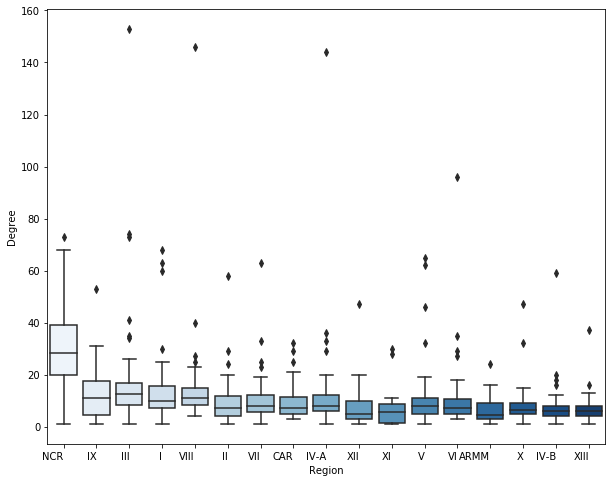

In [20]:
fig, ax = plt.subplots(figsize=(10,8))

# fig = plt.figure()
sns.boxplot(data=df_deg, x='Region', y='Degree', palette='Blues',
            order=upper_fence.sort_values(ascending=False).index)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right');

In [21]:
df_deg['Outlierness'] = df_deg['Degree'] - df_deg['Region'].map(upper_fence)
deg_outlier = df_deg[df_deg['Outlierness'] > 0].groupby('Region')['Outlierness'].agg(['min', 'max', 'mean', 'median', 'count'])
deg_outlier

,min,max,mean,median,count
Region,,,,,
ARMM,6.000,6.000,6.000000,6.000,1
CAR,3.750,10.750,7.416667,7.750,3
I,1.750,39.750,27.000000,33.250,4
II,0.625,34.625,13.625000,5.625,3
III,4.500,123.500,38.833333,27.500,6
IV-A,8.000,123.000,39.500000,13.500,4
IV-B,2.000,45.000,14.250000,5.000,4
IX,16.000,16.000,16.000000,16.000,1
NCR,4.875,4.875,4.875000,4.875,1


### Degree (RHU)

In [22]:
import seaborn as sns

In [23]:
region_deg = {}
for region in nodes['REGION'].unique():
    deg = list(dict(G.in_degree(nodes[(nodes['HF_TYPE']=='RURAL HEALTH UNIT') & (nodes['REGION']==region)]['SHORT_HFCODE'])).values())
    region_deg[region] = deg

In [24]:
df_deg = pd.DataFrame(list(itertools.chain(*[list(zip(len(j) * [i], j)) for i, j in region_deg.items()]))).rename({0:'Region', 1:'Degree'}, axis=1)#.boxplot(by=0)

In [25]:
region_map = {'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)':'ARMM',
       'CORDILLERA ADMINISTRA TIVE REGION (CAR)':'CAR',
       'REGION IV-B (MIMAROPA)':'IV-B', 'NATIONAL CAPITAL REGION (NCR)':'NCR',
       'REGION X (NORTHERN MINDANAO)':'X', 'REGION XI (DAVAO REGION)':'XI',
       'REGION XII (SOCCSKSA RGEN)':'XII', 'REGION XIII (CARAGA)':'XIII',
       'REGION I (ILOCOS REGION)':'I', 'REGION II (CAGAYAN VALLEY)':'II',
       'REGION III (CENTRAL LUZON)':'III', 'REGION IV-A (CALABAR ZON)':'IV-A',
       'REGION V (BICOL REGION)':'V', 'REGION VI (WESTERN VISAYAS)':'VI',
       'REGION VII (CENTRAL VISAYAS)':'VII', 'REGION VIII (EASTERN VISAYAS)':'VIII',
       'REGION IX (ZAMBOANGA PENINSULA)':'IX'}

In [26]:
df_deg['Region'] = df_deg['Region'].map(region_map)

In [27]:
(df_deg.groupby('Region')['Degree']
 .agg(['min', 'max', 'mean', 'median', 'count']).sort_values(by='Region')
 [['max', 'mean', 'median', 'count']]
.style
#  .highlight_max(subset='mean', color='lightskyblue')
# .highlight_min(subset=['mean', 'median', 'count'], axis=0, color='lightskyblue')
.background_gradient(cmap='Blues'))

,max,mean,median,count
Region,,,,
ARMM,43,3.72368,1,76
CAR,27,7.54082,6,98
I,58,9.66216,7,148
II,45,13.6279,11,86
III,24,6.53409,5,264
IV-A,60,9.96721,8,183
IV-B,50,13.8354,11,79
IX,39,8.04167,6.5,96
NCR,25,0.291667,0,384


### Degree Outliers (RHU)

In [28]:
upper_fence = df_deg.groupby('Region')['Degree'].quantile(0.75) + 1.5 * (df_deg.groupby('Region')['Degree'].quantile(0.75) - df_deg.groupby('Region')['Degree'].quantile(0.25))

In [29]:
df_deg[df_deg['Region']=='CAR']

,Region,Degree
76,CAR,5
77,CAR,20
78,CAR,0
79,CAR,8
80,CAR,0
...,...,...
169,CAR,13
170,CAR,7
171,CAR,7
172,CAR,6


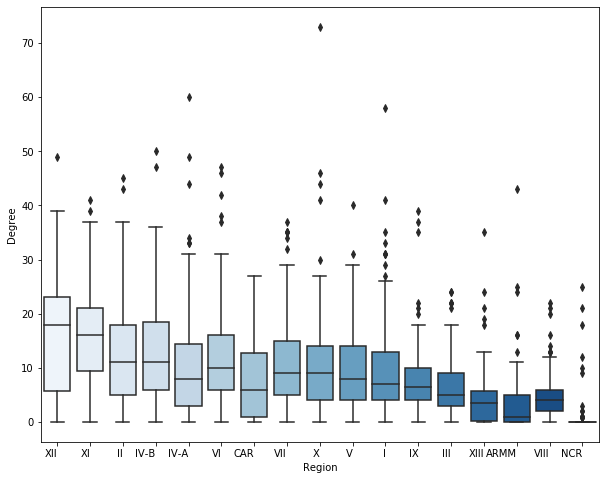

In [30]:
fig, ax = plt.subplots(figsize=(10,8))

# fig = plt.figure()
sns.boxplot(data=df_deg, x='Region', y='Degree', palette='Blues',
            order=upper_fence.sort_values(ascending=False).index)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right');

In [31]:
df_deg['Outlierness'] = df_deg['Degree'] - df_deg['Region'].map(upper_fence)
deg_outlier_rhu = df_deg[df_deg['Outlierness'] > 0].groupby('Region')['Outlierness'].agg(['min', 'max', 'mean', 'median', 'count'])
deg_outlier_rhu.loc['CAR'] = 0

### Average path length

In [32]:
sp = list(nx.all_pairs_dijkstra_path_length(G, weight='DIST'))

In [33]:
sp = pd.DataFrame(sp).set_index(0)[1].to_dict()

##### BHS -> RHU path

In [34]:
bhs_rhu_ave_sp = {}
for rhu_node in rhu_nodes:
    ave_sp = 0
    N = 0
    for bhs_node in bhs_nodes:
        if sp.get(bhs_node) and sp.get(bhs_node, {}).get(rhu_node):
            ave_sp += sp[bhs_node][rhu_node]
            N += 1
    if N:
        ave_sp /= N
        bhs_rhu_ave_sp[rhu_node] = ave_sp

In [35]:
df_bhs_rhu = pd.DataFrame(bhs_rhu_ave_sp.items(), columns=['HF_CODE', 'AVE_SPL'])
df_bhs_rhu['REGION'] = df_bhs_rhu['HF_CODE'].map(nodes['REGION']).map(region_map)

In [36]:
bhs_rhu_spl = df_bhs_rhu.groupby('REGION')['AVE_SPL'].agg(['min', 'max', 'mean', 'median', 'count'])

In [37]:
bhs_rhu_spl

,min,max,mean,median,count
REGION,,,,,
ARMM,0.649289,30.094905,5.555199,4.055974,43
CAR,1.518987,21.322759,6.019620,5.026051,75
I,0.003270,31.656414,4.453676,3.590668,140
II,2.391830,31.657728,5.754392,5.396387,82
III,0.090624,24.479212,3.185737,2.704451,237
IV-A,0.211387,30.291852,3.931670,3.347734,157
IV-B,2.339802,51.197031,8.056442,5.812716,75
IX,0.860555,42.921784,6.716191,4.831967,92
NCR,0.251464,73.301590,14.818221,3.231071,19


##### Comparison with Degree Outliers

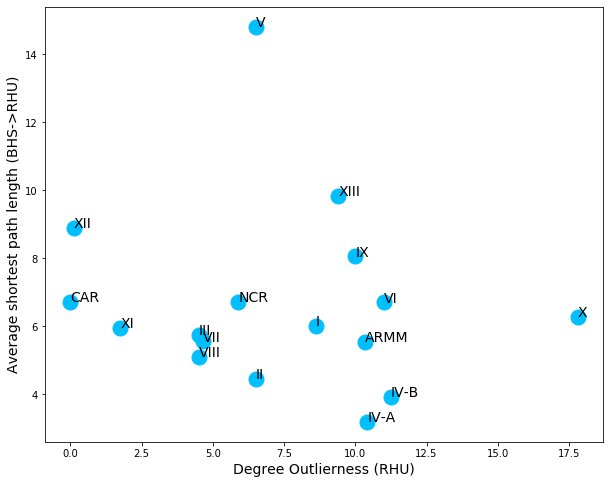

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(deg_outlier_rhu['mean'], bhs_rhu_spl['mean'], 'o', color='deepskyblue', 
        markersize='15')
for i,j,k in zip(deg_outlier_rhu['mean'].values, bhs_rhu_spl['mean'].values, list(deg_outlier_rhu.index)):
    ax.text(i,j,k, fontsize=14)
ax.set_xlabel("Degree Outlierness (RHU)", fontsize=14)
ax.set_ylabel("Average shortest path length (BHS->RHU)", fontsize=14);

##### RHU -> HOSP path

In [39]:
rhu_hosp_ave_sp = {}
for hosp_node in hosp_nodes:
    ave_sp = 0
    N = 0
    for rhu_node in rhu_nodes:
        if sp.get(rhu_node) and sp.get(rhu_node, {}).get(hosp_node):
            ave_sp += sp[rhu_node][hosp_node]
            N += 1
    if N:
        ave_sp /= N
        rhu_hosp_ave_sp[hosp_node] = ave_sp

In [40]:
df_rhu_hosp = pd.DataFrame(rhu_hosp_ave_sp.items(), columns=['HF_CODE', 'AVE_SPL'])
df_rhu_hosp['REGION'] = df_rhu_hosp['HF_CODE'].map(nodes['REGION']).map(region_map)

In [41]:
rhu_hosp_spl = df_rhu_hosp.groupby('REGION')['AVE_SPL'].agg(['min', 'max', 'mean', 'median', 'count'])
rhu_hosp_spl

,min,max,mean,median,count
REGION,,,,,
ARMM,13.962185,52.735692,30.149258,32.533763,18
CAR,6.515990,30.507583,16.465053,15.996059,35
I,5.734009,34.926724,16.853573,14.635240,36
II,0.224660,43.619413,18.391035,14.649935,32
III,3.534404,33.860918,12.974554,10.794383,57
IV-A,3.127798,72.941863,16.033547,15.330127,57
IV-B,5.941933,54.632104,27.001538,25.505928,27
IX,0.424602,56.186424,23.804782,22.073029,21
NCR,1.197162,33.929120,7.209383,3.624081,45


##### Comparison with Degree Outliers

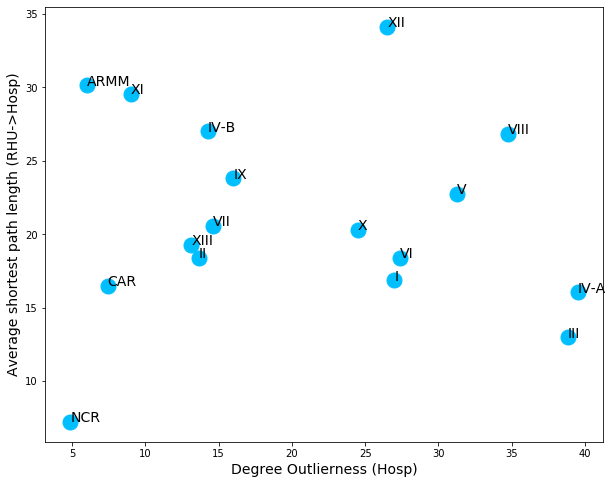

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(deg_outlier['mean'], rhu_hosp_spl['mean'], 'o', color='deepskyblue', 
        markersize='15')
for i,j,k in zip(deg_outlier['mean'].values, rhu_hosp_spl['mean'].values, 
                 list(deg_outlier.index)):
    ax.text(i,j,k, fontsize=14)
ax.set_xlabel("Degree Outlierness (Hosp)", fontsize=14)
ax.set_ylabel("Average shortest path length (RHU->Hosp)", fontsize=14);

#I changed the ylabel to RHU->Hosp

##### BHS -> HOSP path

In [43]:
bhs_hosp_ave_sp = {}
for hosp_node in hosp_nodes:
    ave_sp = 0
    N = 0
    for bhs_node in bhs_nodes:
        if sp.get(bhs_node) and sp.get(bhs_node, {}).get(hosp_node):
            ave_sp += sp[bhs_node][hosp_node]
            N += 1
    if N:
        ave_sp /= N
        bhs_hosp_ave_sp[hosp_node] = ave_sp

In [44]:
df_bhs_hosp = pd.DataFrame(bhs_hosp_ave_sp.items(), columns=['HF_CODE', 'AVE_SPL'])
df_bhs_hosp['REGION'] = df_bhs_hosp['HF_CODE'].map(nodes['REGION']).map(region_map)

In [45]:
bhs_hosp_spl = df_bhs_hosp.groupby('REGION')['AVE_SPL'].agg(['min', 'max', 'mean', 'median', 'count'])
bhs_hosp_spl

,min,max,mean,median,count
REGION,,,,,
ARMM,4.514683,65.315743,35.227616,38.248608,17
CAR,10.496147,40.529846,22.461655,21.810185,35
I,3.775258,36.868836,18.458360,16.845460,39
II,4.400319,49.010055,21.305409,21.137520,35
III,1.273738,37.934485,15.555438,12.757185,62
IV-A,1.000000,78.270904,18.078267,15.302924,60
IV-B,3.775258,56.020411,29.101808,28.420557,30
IX,0.868617,61.034463,25.666220,24.705947,23
NCR,1.214162,68.624784,19.190377,6.627693,41


##### Comparison with Degree Outliers

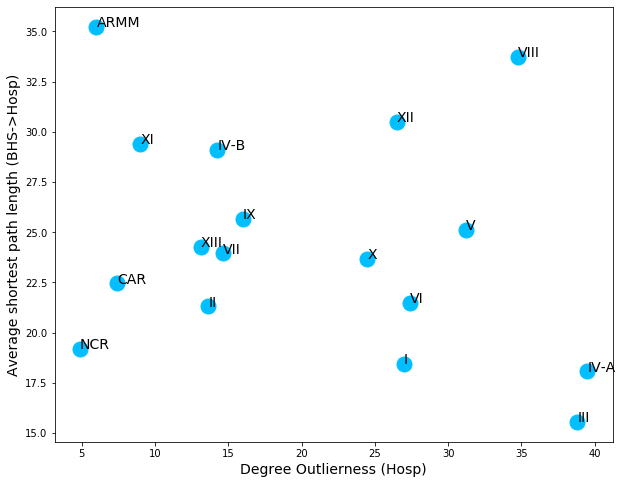

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(deg_outlier['mean'], bhs_hosp_spl['mean'], 'o', color='deepskyblue', 
        markersize='15')
for i,j,k in zip(deg_outlier['mean'].values, bhs_hosp_spl['mean'].values, list(deg_outlier.index)):
    ax.text(i,j,k, fontsize=14)
ax.set_xlabel("Degree Outlierness (Hosp)", fontsize=14)
ax.set_ylabel("Average shortest path length (BHS->Hosp)", fontsize=14);


## I changed the ylabel to BHS -> Hosp

## Simulations
After characterizing the network, further analysis were performed by simulating what would happen to the network as higher percentages of the population enters the system. That is, the facilities that would overload are identified based on the bed capacity.

In [47]:
nodes.groupby('HF_TYPE')['CATCHMENT'].describe()

,count,mean,std,min,25%,50%,75%,max
HF_TYPE,,,,,,,,
BARANGAY HEALTH STATION,17435.0,3800.183309,6013.845024,0.0,1302.00,2444.0,4408.50,123708.0
HOSPITAL,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INFIRMARY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RURAL HEALTH UNIT,2172.0,38663.139503,44947.384236,0.0,16981.75,30224.0,46929.25,903309.0


In [48]:
intake = nodes.loc[(nodes['HF_TYPE']=='RURAL HEALTH UNIT') | (nodes['HF_TYPE']=='BARANGAY HEALTH STATION'), ['REGION', 'CATCHMENT', 'HF_TYPE']]

In [49]:
intake.groupby('REGION')['CATCHMENT'].agg(['mean','median', 'min', 'max'])

,mean,median,min,max
REGION,,,,
AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),9252.728460,2682.0,0.0,222885.0
CORDILLERA ADMINISTRA TIVE REGION (CAR),3688.141975,1187.0,0.0,134461.0
NATIONAL CAPITAL REGION (NCR),30745.293506,25084.0,0.0,290977.0
REGION I (ILOCOS REGION),6133.943131,2556.0,0.0,204135.0
REGION II (CAGAYAN VALLEY),4528.668281,1826.0,0.0,158245.0
REGION III (CENTRAL LUZON),9866.274949,3700.5,0.0,260691.0
REGION IV-A (CALABAR ZON),9040.417355,3122.5,0.0,463727.0
REGION IV-B (MIMAROPA),5363.064924,2104.5,0.0,272190.0
REGION IX (ZAMBOANGA PENINSULA),9427.200000,3773.5,0.0,903309.0


In [50]:
num_iter=1000
#check changes in the system if 0.001% to 1% of population enters the HCPN;
pop_prop = 0.00001
hosp_zero_cap = nodes[((nodes['HF_TYPE']=='HOSPITAL') | (nodes['HF_TYPE']=='INFIRMARY')) & (nodes['BED_CAP']==0)].SHORT_HFCODE.values

In [51]:
len(hosp_zero_cap)

0

Text(0, 0.5, 'Percentage of isolated RHUs')

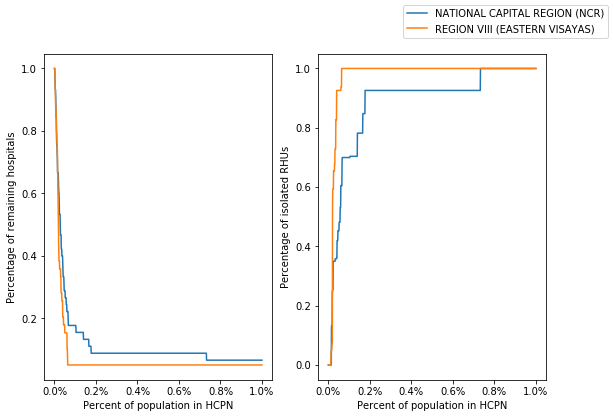

In [55]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 6))

intake_t = intake['CATCHMENT'] * pop_prop
df_isolates = pd.DataFrame()
df_rem_hosps = pd.DataFrame()
# ax2 = ax1.twinx()
for region in ['NATIONAL CAPITAL REGION (NCR)', 'REGION VIII (EASTERN VISAYAS)']:
    rhu_reg = nodes[(nodes['REGION']==region) & (nodes['HF_TYPE']=='RURAL HEALTH UNIT')]['SHORT_HFCODE']
    hosp_reg = nodes[(nodes['REGION']==region) & ((nodes['HF_TYPE']=='HOSPITAL') | (nodes['HF_TYPE']=='INFIRMARY'))]['SHORT_HFCODE']
    G_reg = G.subgraph(rhu_reg.tolist() + hosp_reg.tolist()).copy()
    hosp_reg_connected = [i for i in hosp_reg if ((i not in nx.isolates(G_reg)) and (i not in hosp_zero_cap))]
    remaining_hosps = [len(hosp_reg_connected)]
    G_reg.remove_nodes_from(list(nx.isolates(G_reg)))
    G_reg.remove_nodes_from(hosp_zero_cap)
    num_isolates = [0]
    remaining_hosp = [i for i, j in G_reg.nodes(data=True) if ((j['HF_TYPE']=='HOSPITAL') or (j['HF_TYPE']=='INFIRMARY'))]
    # t=0
    # while remaining_hosp:
    for t in range(num_iter):
        removed_hosps = []
        for rhu in rhu_reg:
            try:
                N = len(list(G_reg.neighbors(rhu)))
            except nx.NetworkXError:
                continue
            nearby_hosps = list(G_reg.neighbors(rhu))
#             dist_sum = G_reg.out_degree(rhu, weight='DIST')
            dist_sum = sum([G_reg[rhu][i]['DIST'] for i in nearby_hosps if G_reg[rhu][i]['DIST']==G_reg[rhu][i]['DIST']])
            for hosp in nearby_hosps:
                if len(nearby_hosps)==1:
                    prob_hosp = 1
                else:
                    prob_hosp = (1 - G_reg[rhu][hosp]['DIST'] / dist_sum) if G_reg[rhu][hosp]['DIST']==G_reg[rhu][hosp]['DIST'] else 0
                new_patient = intake_t[rhu] * prob_hosp if intake_t[rhu]==intake_t[rhu] else 0
                add_one = 1 if random.random()<new_patient%1 else 0
                if (G_reg.nodes()[hosp].get('patients', 0) + int(new_patient) + add_one) > G_reg.nodes()[hosp]['BED_CAP']:
                    G_reg.remove_node(hosp)
                    removed_hosps.append(hosp)
                else:
                    nx.set_node_attributes(G_reg, {hosp: G_reg.nodes()[hosp].get('patients', 0) + int(new_patient) + add_one}, 'patients')
        remaining_hosp = [i for i, j in G_reg.nodes(data=True) if ((j['HF_TYPE']=='HOSPITAL') or (j['HF_TYPE']=='INFIRMARY'))]
        remaining_hosps.append(len(remaining_hosp))
        num_isolates.append(len(list(nx.isolates(G_reg))))
    #     print(t, removed_hosps)
    df_rem_hosps.loc[region, "0.05%"] = remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / remaining_hosps[0]
    df_rem_hosps.loc[region, "0.5%"] = remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / remaining_hosps[0]
    df_isolates.loc[region, "0.05%"] = num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / num_isolates[-1]
    df_isolates.loc[region, "0.5%"] = num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / num_isolates[-1]
    
#     print("At 0.05%, remaining hosps are", remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / remaining_hosps[0], region)
#     print("At 0.5%, remaining hosps are", remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / remaining_hosps[0], region)
#     print("At 0.05%, the isolated RHUs are", num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / num_isolates[-1], region)
#     print("At 0.5%, the isolated RHUs are", num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / num_isolates[-1], region)
    ax1.plot(pop_prop * np.arange(num_iter+1), [i/remaining_hosps[0] for i in remaining_hosps], label=region)
    ax2.plot(pop_prop * np.arange(num_iter+1), [i/num_isolates[-1] for i in num_isolates])
fig.legend()
ax1.set_xlabel('Percent of population in HCPN')
ax2.set_xlabel('Percent of population in HCPN')

ax1.set_xticklabels(['-0.2%', '0.0%', '0.2%', '0.4%', '0.6%', '0.8%', '1.0%'])
ax2.set_xticklabels(['-0.2%', '0.0%', '0.2%', '0.4%', '0.6%', '0.8%', '1.0%'])
ax1.set_ylabel('Percentage of remaining hospitals')
ax2.set_ylabel('Percentage of isolated RHUs')
    #     t+=1
    #     break

Text(0, 0.5, 'Percentage of isolated RHUs')

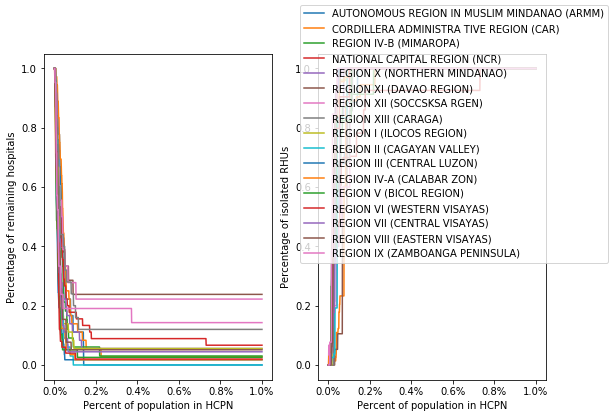

In [56]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 6))

intake_t = intake['CATCHMENT'] * pop_prop
df_isolates = pd.DataFrame()
df_rem_hosps = pd.DataFrame()
# ax2 = ax1.twinx()
for region in nodes['REGION'].unique():
    rhu_reg = nodes[(nodes['REGION']==region) & (nodes['HF_TYPE']=='RURAL HEALTH UNIT')]['SHORT_HFCODE']
    hosp_reg = nodes[(nodes['REGION']==region) & ((nodes['HF_TYPE']=='HOSPITAL') | (nodes['HF_TYPE']=='INFIRMARY'))]['SHORT_HFCODE']
    G_reg = G.subgraph(rhu_reg.tolist() + hosp_reg.tolist()).copy()
    hosp_reg_connected = [i for i in hosp_reg if ((i not in nx.isolates(G_reg)) and (i not in hosp_zero_cap))]
    remaining_hosps = [len(hosp_reg_connected)]
    G_reg.remove_nodes_from(list(nx.isolates(G_reg)))
    G_reg.remove_nodes_from(hosp_zero_cap)
    num_isolates = [0]
    remaining_hosp = [i for i, j in G_reg.nodes(data=True) if ((j['HF_TYPE']=='HOSPITAL') or (j['HF_TYPE']=='INFIRMARY'))]
    # t=0
    # while remaining_hosp:
    for t in range(num_iter):
        removed_hosps = []
        for rhu in rhu_reg:
            try:
                N = len(list(G_reg.neighbors(rhu)))
            except nx.NetworkXError:
                continue
            nearby_hosps = list(G_reg.neighbors(rhu))
#             dist_sum = G_reg.out_degree(rhu, weight='DIST')
            dist_sum = sum([G_reg[rhu][i]['DIST'] for i in nearby_hosps if G_reg[rhu][i]['DIST']==G_reg[rhu][i]['DIST']])
            for hosp in nearby_hosps:
                if len(nearby_hosps)==1:
                    prob_hosp = 1
                else:
                    prob_hosp = (1 - G_reg[rhu][hosp]['DIST'] / dist_sum) if G_reg[rhu][hosp]['DIST']==G_reg[rhu][hosp]['DIST'] else 0
                new_patient = intake_t[rhu] * prob_hosp if intake_t[rhu]==intake_t[rhu] else 0
                add_one = 1 if random.random()<new_patient%1 else 0
                if (G_reg.nodes()[hosp].get('patients', 0) + int(new_patient) + add_one) > G_reg.nodes()[hosp]['BED_CAP']:
                    G_reg.remove_node(hosp)
                    removed_hosps.append(hosp)
                else:
                    nx.set_node_attributes(G_reg, {hosp: G_reg.nodes()[hosp].get('patients', 0) + int(new_patient) + add_one}, 'patients')
        remaining_hosp = [i for i, j in G_reg.nodes(data=True) if ((j['HF_TYPE']=='HOSPITAL') or (j['HF_TYPE']=='INFIRMARY'))]
        remaining_hosps.append(len(remaining_hosp))
        num_isolates.append(len(list(nx.isolates(G_reg))))
    #     print(t, removed_hosps)
    df_rem_hosps.loc[region, "0.05%"] = remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / remaining_hosps[0]
    df_rem_hosps.loc[region, "0.5%"] = remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / remaining_hosps[0]
    df_isolates.loc[region, "0.05%"] = num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / num_isolates[-1]
    df_isolates.loc[region, "0.5%"] = num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / num_isolates[-1]
    
#     print("At 0.05%, remaining hosps are", remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / remaining_hosps[0], region)
#     print("At 0.5%, remaining hosps are", remaining_hosps[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / remaining_hosps[0], region)
#     print("At 0.05%, the isolated RHUs are", num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.0005)[0][0]] / num_isolates[-1], region)
#     print("At 0.5%, the isolated RHUs are", num_isolates[np.where(pop_prop * np.arange(num_iter+1)==0.005)[0][0]] / num_isolates[-1], region)
    ax1.plot(pop_prop * np.arange(num_iter+1), [i/remaining_hosps[0] for i in remaining_hosps], label=region)
    ax2.plot(pop_prop * np.arange(num_iter+1), [i/num_isolates[-1] for i in num_isolates])
fig.legend()
ax1.set_xlabel('Percent of population in HCPN')
ax2.set_xlabel('Percent of population in HCPN')

ax1.set_xticklabels(['-0.2%', '0.0%', '0.2%', '0.4%', '0.6%', '0.8%', '1.0%'])
ax2.set_xticklabels(['-0.2%', '0.0%', '0.2%', '0.4%', '0.6%', '0.8%', '1.0%'])
ax1.set_ylabel('Percentage of remaining hospitals')
ax2.set_ylabel('Percentage of isolated RHUs')
    #     t+=1
    #     break

In [57]:
print("Remaining hospitals")
(df_rem_hosps*100).style.background_gradient()

Remaining hospitals


,0.05%,0.5%
AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),33.3333,0
CORDILLERA ADMINISTRA TIVE REGION (CAR),36.1111,2.77778
REGION IV-B (MIMAROPA),21.2121,3.0303
NATIONAL CAPITAL REGION (NCR),26.6667,8.88889
REGION X (NORTHERN MINDANAO),22.2222,5.55556
REGION XI (DAVAO REGION),33.3333,23.8095
REGION XII (SOCCSKSA RGEN),38.8889,22.2222
REGION XIII (CARAGA),36,12
REGION I (ILOCOS REGION),13.8889,5.55556
REGION II (CAGAYAN VALLEY),9.09091,0


In [58]:
print("RHU isolates")
(df_isolates*100).style.background_gradient()

RHU isolates


,0.05%,0.5%
AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),52.8302,100
CORDILLERA ADMINISTRA TIVE REGION (CAR),12.3288,100
REGION IV-B (MIMAROPA),58.6957,100
NATIONAL CAPITAL REGION (NCR),48.1481,92.5926
REGION X (NORTHERN MINDANAO),52.6316,100
REGION XI (DAVAO REGION),10.5263,100
REGION XII (SOCCSKSA RGEN),40,100
REGION XIII (CARAGA),60,100
REGION I (ILOCOS REGION),96.1165,100
REGION II (CAGAYAN VALLEY),83.3333,100
